In [19]:
from learner import Learner

import os

import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import librosa
import numpy as np
import torch
from PIL import Image
from sklearn.utils import shuffle
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

In [20]:
config = [
    ('conv2d', [32, 1, 7, 7, 1, 3]),
    ('relu', [True]),
    ('bn', [32]),
    ('conv2d', [16, 32, 5, 5, 1, 2]),
    ('relu', [True]),
    ('bn', [16]),
    ('conv2d', [8, 16, 3, 3, 1, 1]),
    ('relu', [True]),
    ('bn', [8]),
    ('flatten', []),
    ('linear', [5, 8 * 28 * 28])
]

In [28]:
from birdCallNShot import BirdCallNShot

db_train = BirdCallNShot('birdCall',
                       batchsz=32,
                       n_way=5,
                       k_shot=1,
                       k_query=15,
                       SPEC_SHAPE = (28,28))

DB: train (99, 100, 28, 28, 1) test (33, 100, 28, 28, 1)


In [29]:
x_spt, y_spt, x_qry, y_qry = map(lambda x: torch.from_numpy(x).to(torch.device('cpu')), db_train.next())
device = torch.device('cpu')

In [30]:
def check_accuracy(data, labels, model, idx = 0):
    # print('Checking accuracy on set')   
    num_correct = 0
    num_samples = 0
    num_data_points = data.shape[0]
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x, y = data[idx], labels[idx]
        x = x.to(device=torch.device("cpu"), dtype=torch.float32)  # move to device, e.g. GPU
        y = y.to(device=torch.device("cpu"), dtype=torch.long)
        scores = model(x)
        _, preds = scores.max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        # print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc
        
def train(data, labels, model, optimizer, epochs=50, idx = 0):
    model = model.to(device=torch.device("cpu"))  # move the model parameters to CPU/GPU    
    test_accuracies = [check_accuracy(x_qry, y_qry, model, idx)]
    for e in range(epochs):
        # print(f"Epoch number: {e}")
        x, y = data[idx], labels[idx]
        model.train()  # put model to training mode
        x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)

        scores = model(x)
        loss = F.cross_entropy(scores, y)

        # Zero out all of the gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()

        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()

        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        
        param_idx = 0
        
        for name, param in model.config:
            if name == 'conv2d' or name == 'linear':
                # project U to unitary
                with torch.no_grad():
                    model.parameters()[param_idx].copy_(project_matrix_to_unitary(model.parameters()[param_idx]))
                    model.parameters()[param_idx + 2].copy_(project_matrix_to_unitary(model.parameters()[param_idx + 2]))
                param_idx += 4
            elif name == 'bn':
                param_idx += 2
        
        optimizer.step()

        param_idx = 0
        
        test_accuracies.append(check_accuracy(x_qry, y_qry, model, idx))
    return test_accuracies

In [32]:
import datetime
from torchonn.op.mzi_op import project_matrix_to_unitary

lr_list = [0.01]

print("doing one shot maml accuracies now")
one_shot_test_accuracies = {}

for lr in lr_list:
    models = []
    models = [Learner(config, 1, 28, mb = 16) for _ in range(16)]
    for i in range(16):
        # is trained with 1-shot but the dataset we're using right now is 10-shot
        models[i].load_state_dict(torch.load('onn_birdcall.pth'))
    test_accs = []
    for idx in range(16): 
        if idx % 8 == 0:
            print(f"Time is {datetime.datetime.now()}, idx = {idx}")
        models[idx].eval()
        optimizer = optim.SGD(models[idx].parameters(), lr=lr, momentum=0.9, nesterov=True)
        test_accs.append(train(x_spt, y_spt, models[idx], optimizer, epochs = 20, idx = idx))
    one_shot_test_accuracies[str(lr)] = np.average(np.array(test_accs), axis = 0)
    print(f"For LR = {lr}: {one_shot_test_accuracies[str(lr)]}")

print("doing scratch accuracies now")
scratch_test_accuracies = {}

for lr in lr_list:
    models = []
    models = [Learner(config, 1, 28, mb = 16) for _ in range(16)]
    test_accs = []
    for idx in range(16):
        if idx % 8 == 0:
            print(f"Time is {datetime.datetime.now()}, idx = {idx}")
        models[idx].eval()
        optimizer = optim.SGD(models[idx].parameters(), lr=lr, momentum=0.9, nesterov=True)
        test_accs.append(train(x_spt, y_spt, models[idx], optimizer, epochs = 20, idx = idx))
    scratch_test_accuracies[str(lr)] = np.average(np.array(test_accs), axis = 0)
    print(f"For LR = {lr}: {scratch_test_accuracies[str(lr)]}")

doing one shot maml accuracies now
Time is 2023-08-25 13:46:02.764063, idx = 0
Time is 2023-08-25 13:46:10.428054, idx = 8
For LR = 0.01: [0.19       0.46083333 0.47833333 0.485      0.48666667 0.4875
 0.485      0.48333333 0.48416667 0.48333333 0.48416667 0.48333333
 0.4825     0.4775     0.4775     0.47583333 0.47583333 0.47583333
 0.47666667 0.47666667 0.47583333]
doing scratch accuracies now
Time is 2023-08-25 13:46:18.412438, idx = 0
Time is 2023-08-25 13:46:26.032121, idx = 8
For LR = 0.01: [0.225      0.23583333 0.24916667 0.24916667 0.24916667 0.25
 0.2525     0.2525     0.25583333 0.25833333 0.2575     0.25666667
 0.2575     0.25666667 0.25583333 0.25583333 0.255      0.255
 0.25416667 0.25416667 0.25416667]


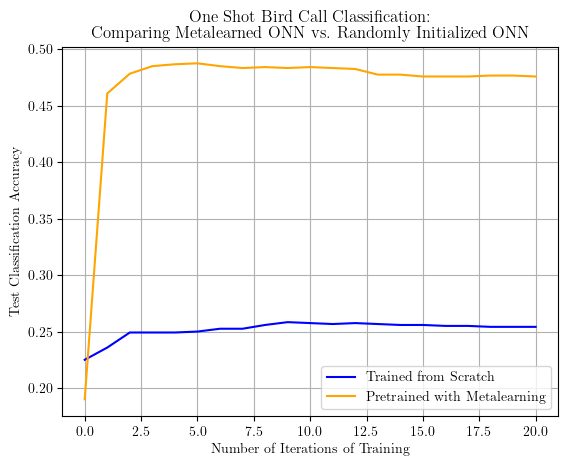

In [33]:
import matplotlib.pyplot as plt

y0 = scratch_test_accuracies[str(0.01)]
y1 = one_shot_test_accuracies[str(0.01)]
plt.plot(np.array(list(range(0, len(y0)))), y0, label='Trained from Scratch', color='blue')
plt.plot(np.array(list(range(0,len(y1)))), y1, label='Pretrained with Metalearning', color='orange')

# Customize the plot
plt.xlabel('Number of Iterations of Training')
plt.ylabel('Test Classification Accuracy')
plt.title('One Shot Bird Call Classification: \nComparing Metalearned ONN vs. Randomly Initialized ONN')
plt.grid(True)
plt.legend()
plt.savefig('onn_one_shot_birdcall_metalearning_comparison_lr=0.01.jpg', format='jpg')
plt.show()

In [36]:
models[0].parameters()[0][0][0] @ models[0].parameters()[0][0][0].T

tensor([[ 1.0002e+00, -9.6396e-05, -1.6627e-04, -1.7223e-04, -8.2491e-05,
          2.8892e-05, -6.1956e-07, -7.6538e-05, -1.2493e-04,  5.5769e-05,
          6.6776e-05,  8.1873e-05,  4.2157e-05,  1.7924e-05, -8.8309e-05,
          1.4226e-04],
        [-9.6396e-05,  9.9989e-01, -8.0362e-05, -9.9241e-05, -5.4932e-05,
         -1.0159e-04, -1.3445e-04, -2.0401e-04, -5.7917e-06,  1.6076e-04,
          6.5170e-05, -1.2777e-05,  8.1525e-05, -3.5829e-04, -4.6657e-05,
         -2.6291e-04],
        [-1.6627e-04, -8.0362e-05,  1.0002e+00,  4.3581e-06,  3.2874e-05,
         -1.5428e-04,  9.2323e-05,  3.6913e-05, -2.8816e-04,  2.9248e-05,
          8.9135e-05,  1.9455e-04, -6.2733e-05,  2.2801e-04,  2.1855e-05,
         -2.0155e-04],
        [-1.7223e-04, -9.9241e-05,  4.3581e-06,  9.9963e-01,  1.5160e-04,
         -1.7712e-04,  9.6012e-05,  2.4488e-04, -1.3618e-04, -1.1232e-04,
         -2.7264e-05,  1.6511e-04, -6.9168e-05,  2.2623e-04, -4.2275e-05,
          1.0320e-04],
        [-8.2491e-05